In [23]:
import parselmouth
from pydub import AudioSegment
import glob
import numpy as np
import pandas as pd
from parselmouth.praat import call
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [24]:
#数据预处理格式
path = r"C:\Users\yx.fan\Desktop\语音筛查\voice_data\model\1.0\health\元音" 
filter=[".m4a",".aac"] 
def other_format(dirname):
    result = []
    for maindir,subdir,file_name_list in os.walk(dirname):
        for filename in file_name_list:
            apath = os.path.join(maindir, filename)
            ext = os.path.splitext(apath)[1] 
            if ext in filter:
                result.append(apath)
    return result
other_format_files = other_format(path)
for filename in other_format_files:
    temp = AudioSegment.from_file(filename,format= filename[-3:])
    temp.export(filename[:-3] + 'wav',format = 'wav')
    os.remove(filename)

In [36]:
# import numpy as np
# import soundfile

# from ppasr.infer_utils.vad_predictor import VADPredictor

# vad_predictor = VADPredictor()

# wav, sr = soundfile.read('dataset/test_long.wav', dtype=np.float32)
# speech_timestamps = vad_predictor.get_speech_timestamps(wav, sr)
# for t in speech_timestamps:
#     crop_wav = wav[t['start']: t['end']]
#     print(crop_wav.shape)

In [109]:
#静音部分切割

def detect_leading_silence(sound, silence_threshold=-30, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms

    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0 # ms

    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size
    return trim_ms


#不同声音参数

def measurePitch(voiceID, f0min, f0max, unit):
    sound = parselmouth.Sound(voiceID) # read the sound
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max) #create a praat pitch object
    meanF0 = call(pitch, "Get mean", 0, 0, unit) # get mean pitch
    stdevF0 = call(pitch, "Get standard deviation", 0 ,0, unit) # get standard deviation
    intensity = call(sound, 'To Intensity', 75.0, 0.0, True)
    meanInten = call(intensity, 'Get mean', 2, 1, 'energy')
    sdInten = call(intensity, 'Get standard deviation', 2, 1)
    
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)
    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq11Shimmer =  call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    
    return meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer,ddpJitter,ddaShimmer,meanInten,sdInten

In [115]:
#不同声音参数整合成数据框
file_list = []
mean_F0_list = []
sd_F0_list = []
hnr_list = []
localJitter_list = []
localabsoluteJitter_list = []
rapJitter_list = []
ppq5Jitter_list = []
ddpJitter_list = []
localShimmer_list = []
localdbShimmer_list = []
apq3Shimmer_list = []
aqpq5Shimmer_list = []
apq11Shimmer_list = []
ddaShimmer_list = []
meanInten_list = []
sdInten_list = []

# Go through all the wave files in the folder and measure pitch
path = r"C:\Users\yx.fan\Desktop\语音筛查\voice_data\model\1.0\type2\元音" 
for wave_file in glob.glob( path + "\\*.wav" ):
    sound = AudioSegment.from_file(wave_file, format="wav")
    start_trim = detect_leading_silence(sound)
    end_trim = detect_leading_silence(sound.reverse())
    duration = len(sound)    
    trimmed_sound = sound[start_trim:duration-end_trim]
    path_changed = wave_file[:-4] + '_trimmed' + '.wav'
    trimmed_sound.export(path_changed, format="wav")
    trimmed_sound = parselmouth.Sound(path_changed)
    (meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer,meanInten,sdInten) = measurePitch(trimmed_sound, 50, 800, "Hertz")
    file_list.append(wave_file) # make an ID list
    mean_F0_list.append(meanF0) # make a mean F0 list
    sd_F0_list.append(stdevF0) # make a sd F0 list
    hnr_list.append(hnr)
    localJitter_list.append(localJitter)
    localabsoluteJitter_list.append(localabsoluteJitter)
    rapJitter_list.append(rapJitter)
    ppq5Jitter_list.append(ppq5Jitter)
    ddpJitter_list.append(ddpJitter)
    localShimmer_list.append(localShimmer)
    localdbShimmer_list.append(localdbShimmer)
    apq3Shimmer_list.append(apq3Shimmer)
    aqpq5Shimmer_list.append(aqpq5Shimmer)
    apq11Shimmer_list.append(apq11Shimmer)
    ddaShimmer_list.append(ddaShimmer)
    meanInten_list.append(meanInten)
    sdInten_list.append(sdInten)
    
df_type2_vowel_tri = pd.DataFrame(np.column_stack([file_list, mean_F0_list, sd_F0_list, hnr_list, localJitter_list, localabsoluteJitter_list, rapJitter_list, ppq5Jitter_list, ddpJitter_list, localShimmer_list, localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list, apq11Shimmer_list, ddaShimmer_list,meanInten_list,sdInten_list]),
                               columns=['voiceID', 'meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter', 'localabsoluteJitter', 'rapJitter', 
                                        'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 
                                        'apq11Shimmer', 'ddaShimmer','meanInten','sdInten'])  


In [202]:
df_healthy_sentence_tri

In [203]:
df_type2_sentence_tri

In [204]:
df_healthy_vowel_tri

In [205]:
df_type2_vowel_tri

In [206]:
#Kmeans-sentence
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
df_healthy_sentence_tri['type'] = list(repeat('healthy',df_healthy_sentence_tri.shape[0]))
df_type2_sentence_tri['type'] = list(repeat('type2',df_type2_sentence_tri.shape[0]))
df_sentence_tri = pd.concat([df_healthy_sentence_tri, df_type2_sentence_tri])
df_sentence_tri = df_sentence_tri.reset_index(drop=True)
df_sentence_tri_label = df_sentence_tri.iloc[:,-1]
df_sentence_tri_data = df_sentence_tri.iloc[:,1:-1]
# df_sentence_tri_data
# df_sentence_tri_label
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_sentence_tri_data)
cluster_labels = kmeans.labels_
cluster_labels
df_sentence_tri['Cluster_kmeans'] = cluster_labels
df_sentence_tri
cross_table = pd.crosstab(df_sentence_tri['Cluster_kmeans'],df_sentence_tri['type'])
print(cross_table)

type            healthy  type2
Cluster_kmeans                
0                   318    230
1                   162    250


d:\software_add\Coding_software\Anaconda\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\software_add\Coding_software\Anaconda\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [207]:
#Kmeans-vowel
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
df_healthy_vowel_tri['type'] = list(repeat('healthy',df_healthy_vowel_tri.shape[0]))
df_type2_vowel_tri['type'] = list(repeat('type2',df_type2_vowel_tri.shape[0]))
df_vowel_tri = pd.concat([df_healthy_vowel_tri, df_type2_vowel_tri])
df_vowel_tri = df_vowel_tri.reset_index(drop=True)
df_vowel_tri_label = df_vowel_tri.iloc[:,-1]
df_vowel_tri_data = df_vowel_tri.iloc[:,1:-1]
# df_sentence_tri_data
# df_sentence_tri_label
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_vowel_tri_data)
cluster_labels = kmeans.labels_
cluster_labels
df_vowel_tri['Cluster_kmeans'] = cluster_labels
df_vowel_tri
cross_table = pd.crosstab(df_vowel_tri['Cluster_kmeans'],df_vowel_tri['type'])
print(cross_table)

type            healthy  type2
Cluster_kmeans                
0                   317    228
1                   163    252


d:\software_add\Coding_software\Anaconda\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\software_add\Coding_software\Anaconda\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


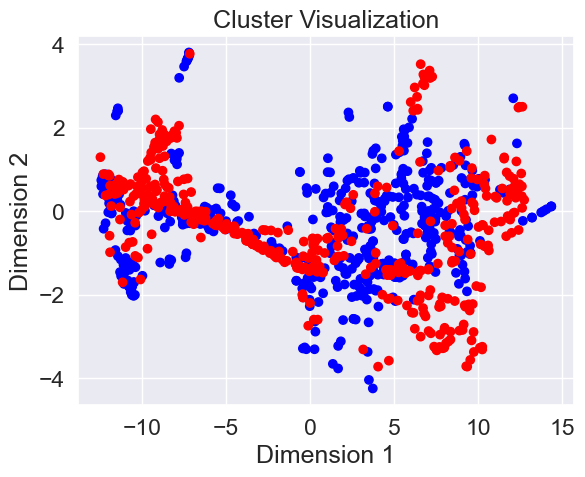

In [257]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

df_healthy_sentence_tri['type'] = list(repeat('healthy',df_healthy_sentence_tri.shape[0]))
df_type2_sentence_tri['type'] = list(repeat('type2',df_type2_sentence_tri.shape[0]))


df_sentence_tri = pd.concat([df_healthy_sentence_tri, df_type2_sentence_tri])

df_sentence_tri = df_sentence_tri.reset_index(drop=True)

# df_sentence_tri_label = df_sentence_tri.iloc[:,-1]

df_sentence_tri['type'] = df_sentence_tri['type'].astype('category')
df_sentence_tri_data = df_sentence_tri.iloc[:,1:-1]
tsne =TSNE(n_components=3)
X_embedded = tsne.fit_transform(df_sentence_tri_data)

color_list = list(repeat('blue',480)) + list(repeat('red',480))

plt.scatter(X_embedded[:,0],X_embedded[:,2],c= color_list)
plt.title('Cluster Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
# plt.legend(['healthy','type2'])
plt.show()



In [322]:
df_sentence_tri

In [321]:
from scipy import stats

df_test_sentence = pd.DataFrame(columns=['meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter', 'localabsoluteJitter', 'rapJitter', 
                                        'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 
                                        'apq11Shimmer', 'ddaShimmer','meanInten','sdInten'])

new_index = df_test_sentence.index.tolist() + list(range(0,1)) #男 女 共同
df_test_sentence = df_test_sentence.reindex(new_index)
df_test_sentence

#转化数据类型
for i in range(0,df_sentence_tri.shape[0]):
    for j in range(1,df_sentence_tri.shape[1]-1):
        df_sentence_tri.iloc[i,j] = pd.to_numeric(df_sentence_tri.iloc[i,j])

for i in range(1,17):
    # print(df_sentence_tri.iloc[0,i])
    df_test_sentence.iloc[0,i-1] = stats.ttest_ind(df_sentence_tri.iloc[0:480,i].tolist(),df_sentence_tri.iloc[480:df_sentence_tri.shape[0],i].tolist()).pvalue

df_test_sentence

,meanF0Hz,stdevF0Hz,HNR,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanInten,sdInten
0,0.672757,0.0,0.016321,0.0,0.000421,0.000011,0.000069,0.00009,0.0008,0.0,0.000044,0.057934,0.000011,0.0,0.612857,0.082869


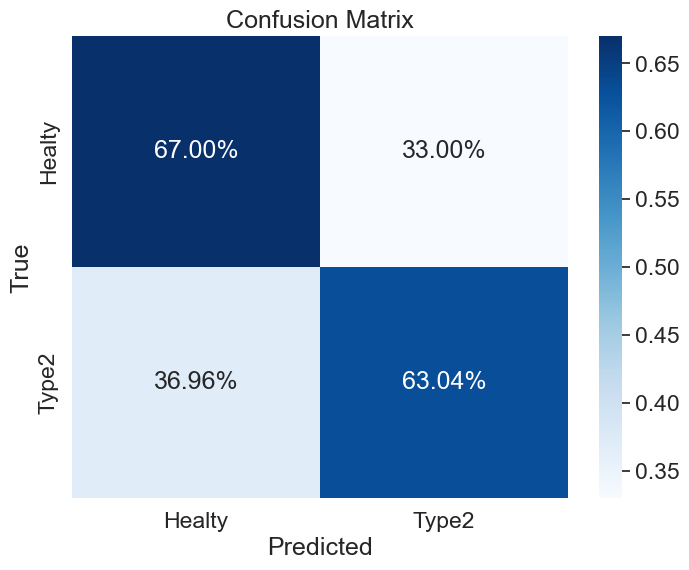

In [402]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(df_sentence_tri.iloc[:,1:-1],df_sentence_tri.iloc[:,-1],test_size=0.2)
svm_classifier = SVC(kernel='linear',probability=True)
svm_classifier.fit(X_train,y_train)
y_pred = svm_classifier.predict(X_test)
y_score = svm_classifier.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test,y_pred,normalize='true')
y_test_replace = pd.DataFrame(y_test).replace({'healthy':0,'type2':1})

labels = ['Healty','Type2']
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='.2%',cmap='Blues',xticklabels=labels,yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


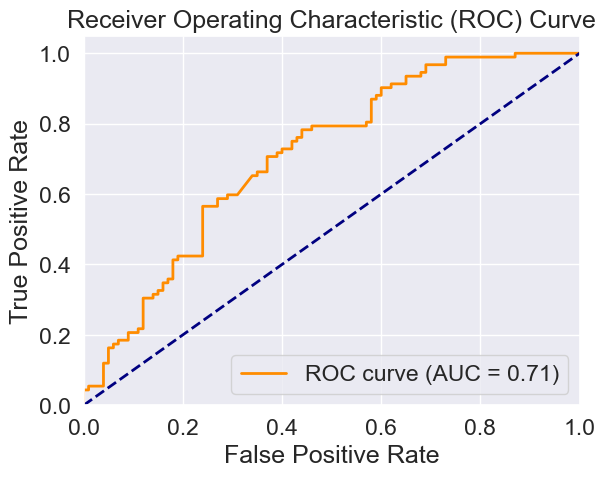

In [403]:
fpr, tpr, thresholds = roc_curve(y_test_replace, y_score)

# 计算曲线下面积（AUC）
auc_score = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [330]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(df_sentence_tri.iloc[:,1:-1],df_sentence_tri.iloc[:,-1],test_size=0.2)
nb_classifier = GaussianNB()
nb_classifier.fit(X_train,y_train)
y_pred = nb_classifier.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
accuracy


0.6197916666666666

In [341]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(df_sentence_tri.iloc[:,1:-1],df_sentence_tri.iloc[:,-1],test_size=0.2)
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train,y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
accuracy


0.9479166666666666

In [338]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(df_sentence_tri.iloc[:,1:-1],df_sentence_tri.iloc[:,-1],test_size=0.2)
DT_classifier = DecisionTreeClassifier()
DT_classifier.fit(X_train,y_train)
y_pred = DT_classifier.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.921875

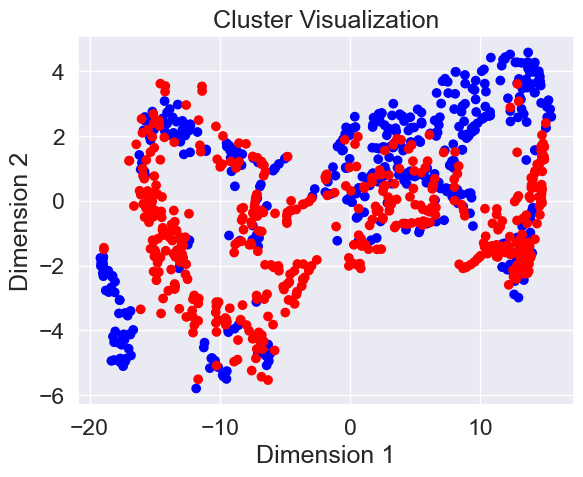

In [260]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

df_healthy_vowel_tri['type'] = list(repeat('healthy',df_healthy_vowel_tri.shape[0]))
df_type2_vowel_tri['type'] = list(repeat('type2',df_type2_vowel_tri.shape[0]))

df_vowel_tri = pd.concat([df_healthy_vowel_tri, df_type2_vowel_tri])
df_vowel_tri = df_vowel_tri.reset_index(drop=True)

df_vowel_tri_label = df_vowel_tri.iloc[:,-1]
df_vowel_tri_data = df_vowel_tri.iloc[:,1:-1]

tsne =TSNE(n_components=3)
X_embedded = tsne.fit_transform(df_vowel_tri_data)

color_list = list(repeat('blue',480)) + list(repeat('red',480))

plt.scatter(X_embedded[:,0],X_embedded[:,2],c=color_list)
plt.title('Cluster Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()



In [333]:
# df_vowel_tri

In [334]:
from scipy import stats

df_test_vowel = pd.DataFrame(columns=['meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter', 'localabsoluteJitter', 'rapJitter', 
                                        'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 
                                        'apq11Shimmer', 'ddaShimmer','meanInten','sdInten'])

new_index = df_test_vowel.index.tolist() + list(range(0,1)) 
df_test_vowel = df_test_vowel.reindex(new_index)
df_test_vowel

#转化数据类型
for i in range(0,df_vowel_tri.shape[0]):
    for j in range(1,df_vowel_tri.shape[1]-1):
        df_vowel_tri.iloc[i,j] = pd.to_numeric(df_vowel_tri.iloc[i,j])

for i in range(1,17):
    # print(df_sentence_tri.iloc[0,i])
    df_test_vowel.iloc[0,i-1] = stats.ttest_ind(df_vowel_tri.iloc[0:480,i].tolist(),df_vowel_tri.iloc[480:df_vowel_tri.shape[0],i].tolist()).pvalue

df_test_vowel

,meanF0Hz,stdevF0Hz,HNR,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanInten,sdInten
0,0.003151,0.143622,0.092063,0.239075,0.341426,0.938106,0.418775,0.005514,0.014387,0.000016,0.022448,0.364745,0.938106,0.000016,0.809091,0.001166


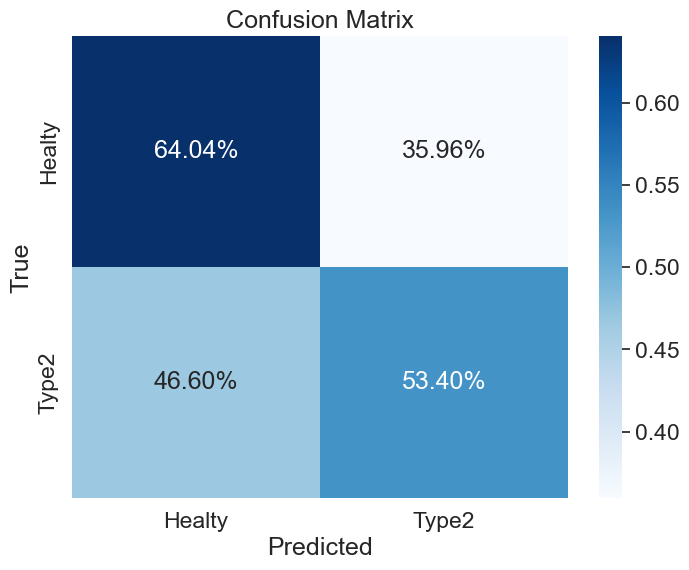

In [397]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(df_vowel_tri.iloc[:,1:-1],df_vowel_tri.iloc[:,-1],test_size=0.2)
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train,y_train)
y_pred = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
accuracy

cm = confusion_matrix(y_test,y_pred,normalize='true')

labels = ['Healty','Type2']
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='.2%',cmap='Blues',xticklabels=labels,yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

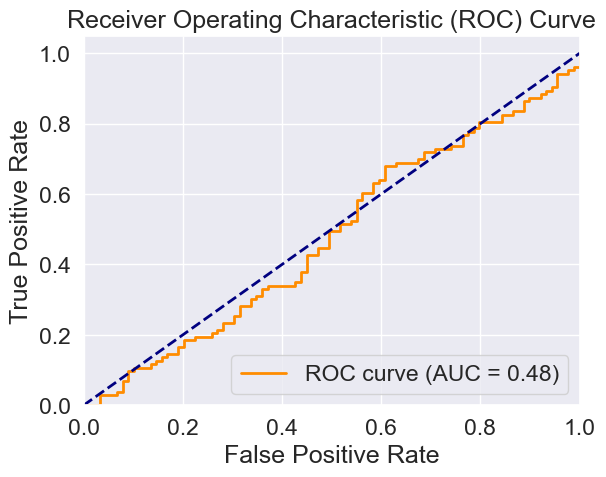

In [398]:
y_test_replace = pd.DataFrame(y_test).replace({'healthy':0,'type2':1})
fpr, tpr, thresholds = roc_curve(y_test_replace, y_score)

# 计算曲线下面积（AUC）
auc_score = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [336]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(df_vowel_tri.iloc[:,1:-1],df_vowel_tri.iloc[:,-1],test_size=0.2)
nb_classifier = GaussianNB()
nb_classifier.fit(X_train,y_train)
y_pred = nb_classifier.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.5416666666666666

In [337]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(df_vowel_tri.iloc[:,1:-1],df_vowel_tri.iloc[:,-1],test_size=0.2)
DT_classifier = DecisionTreeClassifier()
DT_classifier.fit(X_train,y_train)
y_pred = DT_classifier.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.8020833333333334

In [342]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(df_vowel_tri.iloc[:,1:-1],df_vowel_tri.iloc[:,-1],test_size=0.2)
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train,y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.9010416666666666